# 0 - Install Modules

In [52]:
pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1 - Startup



In [53]:
import pandas as pd
import numpy as np

Read raw data

In [54]:
github_link = 'https://raw.githubusercontent.com/JuanRodrigues13/PUC-TCC/main/SKU_DATA.csv'

In [55]:
df_raw = pd.read_csv(github_link)

Setting Features

In [56]:
num_features = len(df_raw['DESCRIPTION'].str.split(',', -1, expand= True).columns)
features_list = []

for i in range(num_features):
  features_list.append('F{}'.format(i+1))

df_raw[features_list] = df_raw['DESCRIPTION'].str.split(',', -1, expand= True)

Setting SKU Family Dataframe

In [57]:
df_family = df_raw[[*['SKU'], *features_list, *['SKU_FAMILY']]]

Setting Box Code Dataframe

In [58]:
df_box = df_raw[[*['SKU'], *features_list, *['BOX_CODE']]]
df_box = df_box[~df_box['BOX_CODE'].isnull()]

# 2 - Part Family Predict Model

Selecting Labels (80%)

In [59]:
df_family =  df_family[df_family['SKU_FAMILY'].isin(['Miscellaneous', 'Motherboards', 'Mechanical', 'Keyboard/Mouse', 'SW', 'Cable', 'Base Unit', 'HDD', 'FPD', 'Card', 'PRC', 'Cover'])] #df_family[df_family['SKU_FAMILY'] != 'Tablet']

Reducing dataset size (20%)

In [60]:
from sklearn.model_selection import train_test_split
temp, df_family =  train_test_split(df_family, test_size=0.2, stratify = df_family['SKU_FAMILY'])

In [61]:
X = df_family[features_list]
y = df_family['SKU_FAMILY']

In [62]:
import category_encoders as ce

In [63]:
encoder = ce.OrdinalEncoder(cols=features_list)

X = encoder.fit_transform(X)

Feature selecting using Chi²

In [64]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

fs = SelectKBest(chi2, k=5)
fit = fs.fit(X, y)

fit.get_support(indices= True)
features = fit.transform(X)
cols = fit.get_support(indices= True)
X = X.iloc[:,cols]

Dropped Features

In [65]:
df_family[features_list].columns.difference(X.columns)

Index(['F1', 'F10', 'F7', 'F8', 'F9'], dtype='object')

# 2.x - Data Split

In [66]:
from sklearn.model_selection import train_test_split
np.random.seed(42)

#Splitting train and test datasets
X_train , X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 42, test_size = 0.25,
                                                    stratify = y)

In [67]:
print(X_train.shape , X_test.shape, y_train.shape, y_test.shape)

(27536, 5) (9179, 5) (27536,) (9179,)


Imbalance dataset identified

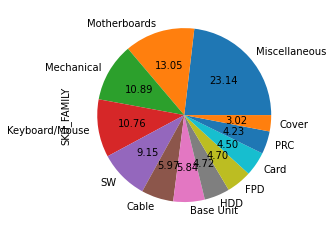

In [68]:
y_train.value_counts().plot.pie(autopct='%.2f')

## 2.x - Running Classifier Models

Setting classifiers

In [69]:
import time

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier

In [70]:
np.random.seed(42)

# Logistic Regression
log_reg = LogisticRegression()

# SVC
svc_clf = SVC()

# KNearestNeighbors
knn_clf = KNeighborsClassifier()

# Decision Tree
tree_clf = tree.DecisionTreeClassifier()

# Gradient Boosting Classifier
grad_clf = GradientBoostingClassifier()

# Random Forest Classifier
rand_clf = RandomForestClassifier(n_estimators=100)

# Naives Bayes
nav_clf = GaussianNB()

# Dummy Classifier
dummy_clf = DummyClassifier(strategy='uniform')


classifiers = [svc_clf, knn_clf, rand_clf]#[log_reg, svc_clf, knn_clf, tree_clf, grad_clf, rand_clf, nav_clf, dummy_clf]

Cross Validate Score

In [71]:
from sklearn.model_selection import cross_val_score

def classifiers_cross_val_score(X, y, classifiers, cv):
  np.random.seed(42)
  
  columns = ['Classifier', 'Accuracy', 'Precision', 'Recall', 'ROC-AUC', 'F1 Score']
  df_results = pd.DataFrame(data=np.zeros(shape=(len(classifiers),len(columns))), columns= columns)
  count = 0

  for clf in classifiers:
    clf_acc = cross_val_score(clf, X, y, cv=cv, scoring= 'accuracy').mean()
    clf_precision = cross_val_score(clf, X, y, cv=cv, scoring= 'precision_micro').mean()
    clf_recall = cross_val_score(clf, X, y, cv=cv, scoring= 'recall_micro').mean()
    #clf_roc = cross_val_score(clf, X, y, cv=cv, scoring= 'roc_auc').mean()
    clf_f1 = cross_val_score(clf, X, y, cv=cv, scoring= 'f1_micro').mean()

    df_results.loc[count,'Classifier'] = str(clf)
    df_results.loc[count,'Accuracy'] = clf_acc
    df_results.loc[count,'Precision'] = clf_precision
    df_results.loc[count,'Recall'] = clf_recall
    #df_results.loc[count,'ROC-AUC'] = clf_roc
    df_results.loc[count,'F1 Score'] = clf_f1

    count += 1
    print('Loading: {:.0f}%'.format(count/len(classifiers)*100))

  df_results = df_results.sort_values(by=['F1 Score'], ascending=False)

  return df_results

### 2.x.1 - Models Results

Cross Validations

In [72]:
from sklearn.model_selection import RepeatedStratifiedKFold

cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2, random_state= 42)
classifiers_cross_val_score(X_train, y_train, classifiers, cv)

Loading: 33%
Loading: 67%
Loading: 100%


,Classifier,Accuracy,Precision,Recall,ROC-AUC,F1 Score
2,RandomForestClassifier(),0.837522,0.837213,0.840137,0.0,0.836287
1,KNeighborsClassifier(),0.304638,0.304638,0.304638,0.0,0.304638
0,SVC(),0.279670,0.279670,0.279670,0.0,0.279670


## 2.x.2 - Model Improvement and Parameters Boost

In [86]:
from imblearn.over_sampling import SMOTE

# Oversample
oversample = SMOTE()
over_X_train, over_y_train = oversample.fit_resample(X_train, y_train)

# Split Oversampled Data
over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(over_X_train, over_y_train, test_size=0.45, stratify=over_y_train)

In [87]:
print(over_X_train.shape, over_X_test.shape, over_y_train.shape, over_y_test.shape)

(42061, 5) (34415, 5) (42061,) (34415,)


In [88]:
from sklearn.model_selection import RepeatedStratifiedKFold

cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2, random_state= 42)
classifiers_cross_val_score(over_X_train, over_y_train, classifiers, cv)

Loading: 33%
Loading: 67%
Loading: 100%


,Classifier,Accuracy,Precision,Recall,ROC-AUC,F1 Score
2,RandomForestClassifier(),0.800611,0.801336,0.801431,0.0,0.800682
1,KNeighborsClassifier(),0.506312,0.506312,0.506312,0.0,0.506312
0,SVC(),0.311880,0.311880,0.311880,0.0,0.311880


In [ ]:
rand_clf.fit(over_X_train, over_y_train)

In [ ]:
y_pred = rand_clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score

y_pred_train = rand_clf.predict(X_train)

In [ ]:
print('Model accuracy score with criterion entropy: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(15, 15))
disp = plot_confusion_matrix(rand_clf, X_test, y_test,
                                 cmap=plt.cm.Blues, ax=ax)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))